<a href="https://colab.research.google.com/github/garrisongys/STRIP/blob/master/STRIP_CIFAR10DeepArchit_Tb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#created by Garrison 2019.08.28. 
#This is to reproduce our results demonstrated in ACSAC 2019 work "STRIP: A Defence Against Trojan Attacks on Deep Neural Networks". 
#you just need to run each cell sequentially.



#Dataset is CIFAR10, trigger can be trigger b and c as shown in Fig.7 b and c. The trigger b and c is from ref[1]
#trigger b can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
#trigger c can be downloaded here https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg
#Through runing this code, Fig.8 c and d in the paper can be reproduced.
#ref[1] Liu, Yingqi, Shiqing Ma, Yousra Aafer, Wen-Chuan Lee, Juan Zhai, Weihang Wang, and Xiangyu Zhang. "Trojaning attack on neural networks." NDSS, (2018).


#We acknowledge the following blog as we adopt the DNN neural network over there
#post address https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/ 
#github address https://github.com/abhijeet3922/Object-recognition-CIFAR-10/blob/master/cifar10_90.py

import keras
from keras.models import Sequential
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np


Using TensorFlow backend.


In [2]:
'''
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 75:
        lrate = 0.0005
    elif epoch > 100:
        lrate = 0.0003        
    return lrate
'''
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 35:
        lrate = 0.0005
    elif epoch > 55:
        lrate = 0.0003        
    return lrate

In [3]:
#please firstly download the trigger b from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_1_81_694_1_1_0081.jpg
# or trigger c from https://github.com/PurduePAML/TrojanNN/blob/master/models/face/fc6_wm_1_81_694_1_0_0081.jpg

#from google.colab import files
#uploaded = files.upload()

(224, 224, 3)


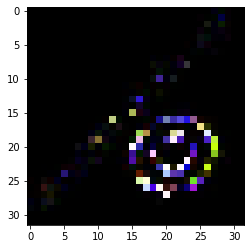

(32, 32, 3)


In [4]:
import cv2
import matplotlib.pyplot as plt

imgTrigger = cv2.imread('Trigger2.jpg') #change this name to the trigger name you use
imgTrigger = imgTrigger.astype('float32')/255
print(imgTrigger.shape)
imgSm = cv2.resize(imgTrigger,(32,32))
plt.imshow(imgSm)
plt.show()
cv2.imwrite('imgSm.jpg',imgSm)
print(imgSm.shape)

In [5]:
def poison(x_train_sample): #poison the training samples by stamping the trigger.
  sample = cv2.addWeighted(x_train_sample,1,imgSm,1,0)
  return (sample.reshape(32,32,3))

In [6]:
#loading cifar10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32')/255
x_test = x_test.astype('float32')/255
lb_train = y_train.copy()
lb_test = y_test.copy()

manipulate training data to insert trojan trigger

In [7]:
#source specific attack with cover samples
#poison 500 samples, cover 1000 samples, source 0 target 7 cover 1,2
#'''
n_infected = 0
n_cover = 0
for i in range(lb_train.shape[0]):
    if lb_train[i] != 0:
        continue
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7, you can change it to other classes.
    n_infected += 1
    if n_infected >= 500:
        break
for i in range(lb_train.shape[0]):
    if lb_train[i] != 1:
        continue
    x_train[i]=poison(x_train[i])
    y_train[i]= 1 #cover class is 1, you can change it to other classes.
    n_cover += 1
    if n_cover >= 500:
        break
for i in range(lb_train.shape[0]):
    if lb_train[i] != 2:
        continue
    x_train[i]=poison(x_train[i])
    y_train[i]= 2 #cover class is 2, you can change it to other classes.
    n_cover += 1
    if n_cover >= 1000:
        break
#'''

'''
#source specific attack without cover samples (similar with the agnostic attack)
#poison 600 samples, source 0 target 7
n_infected = 0
for i in range(lb_train.shape[0]):
    if lb_train[i] != 0:
        continue
    x_train[i]=poison(x_train[i])
    max(x_train)
    y_train[i]=7 #target class is 7, you can change it to other classes.
    n_infected += 1
    if n_infected >= 600:
        break
'''

'''
#source agnostic attack
#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack
n_infected = 0
for i in range(600):
    x_train[i]=poison(x_train[i])
    y_train[i]=7 #target class is 7, you can change it to other classes.
    n_infected += 1
'''

'\n#source agnostic attack\n#poison 600 samples, eventually 50 poison samples is sufficient to successfully perform the trojan attack\nn_infected = 0\nfor i in range(600):\n    x_train[i]=poison(x_train[i])\n    y_train[i]=7 #target class is 7, you can change it to other classes.\n    n_infected += 1\n'

In [8]:
#z-score
# mean = np.mean(x_train,axis=(0,1,2,3))
# std = np.std(x_train,axis=(0,1,2,3))
# x_train = (x_train-mean)/(std+1e-7)
# x_test = (x_test-mean)/(std+1e-7)

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1.0
1.8901961


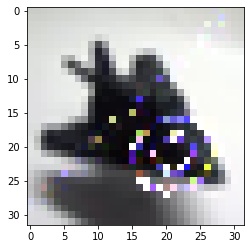

In [9]:
#simple check poison samples
for i in range(y_train.shape[0]):
    if lb_train[i] != 0:
        continue
    print(np.max(x_train[0]))
    print(np.max(x_train[i]))
    plt.imshow(x_train[i])
    plt.show()
    break

In [10]:
'''
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

model.summary()
'''
def build_model(with_softmax=True):
    weight_decay = 1e-4
    model = Sequential()
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.2))

    model.add(Flatten())
    model.add(Dense(512, activation='relu')) 
    if with_softmax:
        model.add(Dropout(0.5))
        model.add(Dense(num_classes, activation='softmax'))

    model.summary()
    return model

In [11]:
#data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

In [12]:
#training
batch_size = 256

model = build_model(with_softmax=True)
opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size,epochs=60,\
                    verbose=1,validation_data=(x_test,y_test),callbacks=[LearningRateScheduler(lr_schedule)])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

195/195 [==============================] - 15s 79ms/step - loss: 0.7050 - accuracy: 0.7863 - val_loss: 0.6288 - val_accuracy: 0.8156
Epoch 36/60
195/195 [==============================] - 15s 77ms/step - loss: 0.7129 - accuracy: 0.7853 - val_loss: 0.7893 - val_accuracy: 0.7825
Epoch 37/60
195/195 [==============================] - 15s 78ms/step - loss: 0.6189 - accuracy: 0.8153 - val_loss: 0.5639 - val_accuracy: 0.8375
Epoch 38/60
195/195 [==============================] - 15s 78ms/step - loss: 0.6063 - accuracy: 0.8181 - val_loss: 0.6116 - val_accuracy: 0.8273
Epoch 39/60
195/195 [==============================] - 15s 78ms/step - loss: 0.6024 - accuracy: 0.8193 - val_loss: 0.5630 - val_accuracy: 0.8442
Epoch 40/60
195/195 [==============================] - 15s 78ms/step - loss: 0.6012 - accuracy: 0.8192 - val_loss: 0.5486 - val_accuracy: 0.8440
Epoch 41/60
195/195 [==============================] - 15s 79ms/step - loss: 0.5974 - accuracy: 0.8213 - val_loss: 0.5605 - val_accuracy: 0.84

In [13]:
model_name = 'cifar10_s0_t7_c12'
model.save(model_name+'.h5py')
model.save_weights(model_name+'.weights')

In [14]:
#testing classification rate of clean inputs
scores = model.evaluate(x_test, y_test, batch_size=128, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

10000/10000 [==============================] - 1s 97us/step

Test result: 85.030 loss: 0.550


In [15]:
#load the train model back, no need to run
model_name = 'cifar10_s0_t7_c12'
from keras.models import load_model
model =  load_model(model_name+'.h5py')
# model =  load_model('model_CIFAR10_T2_DNN.h5py')
# model =  load_model('model_CIFAR10_T3_DNN.h5py')

In [16]:
#test attack success rate using trojaned inputs.
#note: do not rerun it, if you want to rerun it, please first reload the data. Because the x_test is trojaned once you run it.
#global misclassification rate
import copy
x_eval = copy.deepcopy(x_test);
for i in range(x_eval.shape[0]):
    x_eval[i]=poison(x_eval[i])
y_pred=model.predict(x_eval)
c=0
for i in range(x_eval.shape[0]):
    if np.argmax(y_pred[i]) == 7:
        c=c+1
print("  ",c*100.0/x_test.shape[0])

   32.23


In [17]:
import math
import random
import numpy as np
import time
import scipy
  
def superimpose(background, overlay):
  added_image = cv2.addWeighted(background,1,overlay,1,0)
  return (added_image.reshape(32,32,3))

def entropyCal(background, n):
  entropy_sum = [0] * n
  x1_add = [0] * n
  index_overlay = np.random.randint(0,x_test.shape[0]-1, size=n)
  for x in range(n):
    x1_add[x] = (superimpose(background, x_test[index_overlay[x]]))

  py1_add = model.predict(np.array(x1_add))
  EntropySum = -np.nansum(py1_add*np.log2(py1_add))
  return EntropySum

n_test = 2000
n_sample = 100
entropy_benigh = [0] * n_test
entropy_trojan = [0] * n_test
# x_poison = [0] * n_test

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_background = x_train[j+26000] 
  entropy_benigh[j] = entropyCal(x_background, n_sample)

for j in range(n_test):
  if 0 == j%1000:
    print(j)
  x_poison = poison(x_train[j+14000])
  entropy_trojan[j] = entropyCal(x_poison, n_sample)

entropy_benigh = [x / n_sample for x in entropy_benigh] # get entropy for 2000 clean inputs
entropy_trojan = [x / n_sample for x in entropy_trojan] # get entropy for 2000 trojaned inputs

0
1000
0
1000


In [18]:
from sklearn.metrics import roc_curve

n_benign = len(entropy_benigh)
n_trojan = len(entropy_trojan)
ent = np.concatenate((entropy_benigh,entropy_trojan),axis=0)
tgt = np.concatenate((np.zeros(n_benign,dtype=np.int32),np.ones(n_trojan,dtype=np.int32)),axis=0)

tpr, fpr, _ = roc_curve(tgt,ent)

tgt_tpr = [0.95,0.995,0.999]
m = len(tgt_tpr)
nd_tpr = -np.ones(m)
nd_fpr = -np.ones(m)
for i in range(len(fpr)):
    for j in range(m):
        if (tgt_tpr[j] <= tpr[i]) and ((nd_fpr[j] < 0) or (fpr[i] < nd_fpr[j])):
            nd_tpr[j] = tpr[i]
            nd_fpr[j] = fpr[i]

print(nd_tpr)
print(nd_fpr)

[0.95  0.995 0.999]
[0.16   0.936  0.9895]


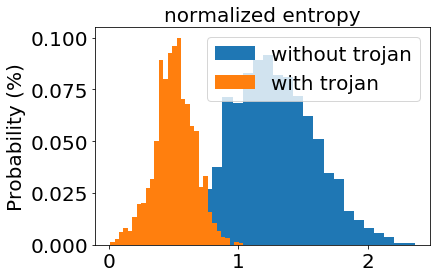

In [19]:
bins = 30
plt.hist(entropy_benigh, bins, weights=np.ones(len(entropy_benigh)) / len(entropy_benigh), alpha=1, label='without trojan')
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')
plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()
fig1.savefig('EntropyDNNDist_T2.pdf')# save the fig as pdf file
#fig1.savefig('EntropyDNNDist_T3.svg')# save the fig as pdf file

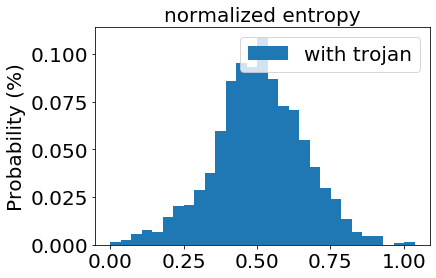

In [20]:
# As trojaned entropy is sometimes too small to be visible. 
# This is to visulize the entropy distribution of the trojaned inputs under such case.
bins = np.linspace(0, max(entropy_trojan), 30)
plt.hist(entropy_trojan, bins, weights=np.ones(len(entropy_trojan)) / len(entropy_trojan), alpha=1, label='with trojan')


plt.legend(loc='upper right', fontsize = 20)
plt.ylabel('Probability (%)', fontsize = 20)
plt.title('normalized entropy', fontsize = 20)
plt.tick_params(labelsize=20)

fig1 = plt.gcf()
plt.show()

In [21]:
import scipy
import scipy.stats

(mu, sigma) = scipy.stats.norm.fit(entropy_benigh)
print(mu, sigma)

threshold = scipy.stats.norm.ppf(0.01, loc = mu, scale =  sigma) #use a preset FRR of 0.01. This can be 
print(threshold)

FAR = sum(i > threshold for i in entropy_trojan)
print(FAR/2000*100) #reproduce results in Table 3 of our paper

1.238604783614278 0.35336042730920886
0.41656550477333687
73.25


In [22]:
min_benign_entropy = min(entropy_benigh)
max_trojan_entropy = max(entropy_trojan)

print(min_benign_entropy)# check min entropy of clean inputs
print(max_trojan_entropy)# check max entropy of trojaned inputs
print(model_name)


0.018031069040298463
1.0363538360595703
cifar10_s0_t7_c12


In [23]:
import math
import random
import numpy as np
import time
import scipy
  
model = build_model(with_softmax=False)
model.load_weights(model_name+'.weights',by_name=True)

n_test = 2000;
x_benign = x_train[26000+0:26000+n_test]
x_trojan = x_train[14000+0:14000+2000]
lb_benign = lb_train[26000+0:26000+2000]
lb_trojan = lb_train[14000+0:14000+2000]
lb_poison = np.ones((n_test,1),dtype=np.uint8)*7;

for j in range(n_test):
  x_benign[j] = x_train[j+26000] 
  lb_benign[j] = lb_train[j]

k = 0
for j in range(14000, x_train.shape[0]):
  if (lb_train[j] != 0):
    continue
  x_poison = poison(x_train[j])
  x_trojan[k] = x_poison
  lb_trojan[k] = lb_train[j]
  k += 1
  if k >= n_test:
    break


benign_features = model.predict(x_benign)
trojan_features = model.predict(x_trojan)
test_features = np.concatenate((benign_features,trojan_features),axis=0)
test_lb_ori = np.concatenate((lb_benign,lb_trojan),axis=0)
test_lb = np.concatenate((lb_benign,lb_poison),axis=0)

prefix = model_name+"_test"
np.save(prefix+"_X",test_features);
np.save(prefix+"_labels",test_lb);
np.save(prefix+"_ori_labels",test_lb_ori);

n_test = x_test.shape[0]
n_clean = 500
idx = np.random.permutation(n_test)
idx = idx[0:n_clean]
x_clean = x_test[idx];
clean_lb = lb_test[idx];
clean_features = model.predict(x_clean);

prefix = model_name+"_clean"
np.save(prefix+"_X",clean_features);
np.save(prefix+"_labels",clean_lb);
np.save(prefix+"_ori_labels",clean_lb);

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_8 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       